Importing what needs to be imported:

In [1]:
import requests
import pandas as pd
import json
import matplotlib.pyplot as plt  
import numpy as np
import seaborn as sns

This file needed to be downloaded directly.  We couldn't find a way to access it through the API, so we grabbed the csv and just worked on it directly.  We found it at http://inalitic.com/datasets/nhl%20player%20data.html.  There was an issue with the encoding not being utf-8 that we had to correct.

In [181]:
df = pd.read_csv('skater_stats.csv', encoding='latin1')

//anaconda3/lib/python3.7/site-packages/IPython/core/interactiveshell.py:3058: DtypeWarning: Columns (22,23) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


# New API

In [3]:
# Initializing varibables
teamgoalsdict = {}
yeardict = {}
listofgoalgpgBefore = []
listofgoalgpgAfter = []

# The ten seasons prior to the rule changes
seasonindices = ['19931994', '19941995', '19951996', '19961997', '19971998', '19981999', '19992000', '20002001', '20012002', '20022003']

# This for loop makes an API call for each season and then 
# puts each team's GPG into a list
for index in seasonindices:
#     print(index)
    yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=' + index
    r = requests.get(yearhtml, auth=('user', 'pass'))
    nestdict = r.json()
    for i in range(len(nestdict['teams'])):
#         name = nestdict['teams'][i]['teamStats'][0]['splits'][0]['team']['name']
        goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
        listofgoalgpgBefore.append(goalsPerGame)

# The ten seasons after the rule changes
seasonindicesaft = ['20062007', '20072008', '20082009', '20092010', '20102011', '20112012', '20122013', '20132014', '20142015', '20152016']

# This for loop makes an API call for each season and then 
# puts each team's GPG into a list
for index in seasonindicesaft:
#     print(index)
    yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=' + index
    r = requests.get(yearhtml, auth=('user', 'pass'))
    nestdict = r.json()
    for i in range(len(nestdict['teams'])):
#         name = nestdict['teams'][i]['teamStats'][0]['splits'][0]['team']['name']
        goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
        listofgoalgpgAfter.append(goalsPerGame)                

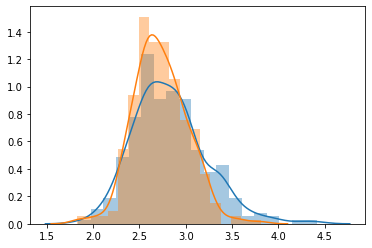

In [4]:
# Quick plot - eda
sns.distplot(listofgoalgpgBefore)
sns.distplot(listofgoalgpgAfter)

For relatively normal graphs, the mean should equal the median.  This is just a quick and dirty way of determining normality.  Probably not the best way, but should be good enough.

In [5]:
np.mean(np.array(listofgoalgpgAfter))/np.median(np.array(listofgoalgpgAfter))

1.0070877970693264

Still gonna bootstrap.  But here is a look without bootstrapping.

In [6]:
import scipy.stats as stats
import statsmodels.stats as sm

stats.ttest_ind(listofgoalgpgBefore, listofgoalgpgAfter)

# print(np.average(np.array(listofgoalgpgBefore)), np.average(np.array(listofgoalgpgAfter)))

Ttest_indResult(statistic=3.442300149495998, pvalue=0.000618864598146791)

### Bootstrapping

In [7]:
sampledgpgBefore = []
sampledgpgAfter = []
bootstrap_means_before = []
bootstrap_means_after = []

for iteration in range(500):
    for gpgs in range(10):
        sampledgpgBefore.append(np.random.choice(listofgoalgpgBefore))
        sampledgpgAfter.append(np.random.choice(listofgoalgpgAfter))
    bootstrap_means_before.append(np.average(sampledgpgBefore))
    bootstrap_means_after.append(np.average(sampledgpgAfter))

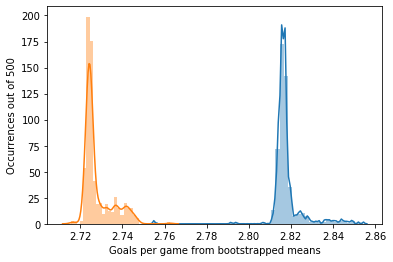

In [8]:
sns.distplot(np.array(bootstrap_means_before), norm_hist=True)
sns.distplot(np.array(bootstrap_means_after), norm_hist=True)
plt.ylabel('Occurrences out of 500');
plt.xlabel('Goals per game from bootstrapped means');


In [9]:
stats.ttest_ind(bootstrap_means_before, bootstrap_means_after)

Ttest_indResult(statistic=194.4564414490776, pvalue=0.0)

Ok so...not the same. Clearly not the same.

# Let's look at ages now

#### H0: There is *not* a statistically significant point decrease in forwards once they've turned 31.

#### Ha: There is a statistically significant point decrease in forwards once they've turned 31.

In [10]:
# Quick DataFrame cleanup.  Here we are looking at scoring points, so we
# are purposefully not looking at defensemen.  They are dropped from the
# DataFrame.

df = df.drop('Unnamed: 0', axis = 1)
d_men = df[df.Pos == " D "].index
df.drop(d_men, inplace=True)

df.head(10)

,Season,Player,Age,Tm,Pos,GP,G,GPG,A,PTS,...,SHA,S,S%,TOI,ATOI,BLK,HIT,FOwin,FOloss,FO%
0,2018,Justin Abdelkader,30.0,DET,LW,75,13,0.1733,22,35,...,-,110,12,"1,241",16:33,40.0,174.0,47.0,50.0,48.5
1,2018,Pontus Aberg,24.0,TOT,LW,53,4,0.0755,12,16,...,-,70,6,645,12:10,8.0,24.0,4.0,8.0,33.3
2,2018,Noel Acciari,26.0,BOS,C,60,10,0.1667,1,11,...,-,66,15,775,12:55,41.0,152.0,42.0,51.0,45.2
3,2018,Kenny Agostino,25.0,BOS,LW,5,-,0.0000,1,1,...,-,11,-,60,12:03,1.0,4.0,0.0,1.0,0.0
4,2018,Sebastian Aho,20.0,CAR,RW,78,29,0.3718,36,65,...,-,200,15,"1,398",17:55,17.0,65.0,78.0,94.0,45.3
8,2018,Michael Amadio,21.0,LAK,C,37,4,0.1081,4,8,...,-,28,14,345,9:19,9.0,18.0,74.0,96.0,43.5
9,2018,Josh Anderson,23.0,CBJ,RW,63,19,0.3016,11,30,...,-,188,10,"1,136",18:02,24.0,109.0,26.0,36.0,41.9
10,2018,Lias Andersson,19.0,NYR,C,7,1,0.1429,1,2,...,-,5,20,84,11:57,3.0,9.0,19.0,28.0,40.4
12,2018,Andy Andreoff,26.0,LAK,LW,45,3,0.0667,6,9,...,-,47,6,423,9:23,11.0,77.0,24.0,29.0,45.3
13,2018,Sven Andrighetto,24.0,COL,RW,50,8,0.1600,14,22,...,-,111,7,724,14:29,18.0,38.0,7.0,15.0,31.8


In [11]:
# Good, D-men are dropped.
df.Pos.unique()

array([' LW ', ' C ', ' RW ', ' RW/LW ', ' LW/RW ', ' RW/C ', ' C/LW ',
       ' LW/C ', ' LW/D ', ' RW/D ', ' C/RW ', ' C/RW/ ', ' D/LW ',
       ' C/LW/ ', ' D/RW ', ' F ', ' W/D ', ' W ', ' C/D '], dtype=object)

In [98]:
# Initializing variables
players_30 = []
df_30 = df.loc[df.Age == 30.0]
df_31 = df.loc[df.Age == 31.0]
df_35 = df.loc[df.Age == 35.0]
series_30 = df_30.Player
series_31 = df_31.Player
series_35 = df_35.Player
player_dict_30 = {}
player_dict_31 = {}
player_dict_35 = {}

# The csv includes asterisks after some player names.  The next two
# for loops remove these asterisks and add {name: [points, games]} as a
# new dictionary entry

for key30, value30 in series_30.iteritems():
    if value30 not in player_dict_30.keys():
        if value30.endswith('*'):
            player_dict_30[value30[:-1]] = df.loc[key30, ['PTS', 'GP']]
        else:
            player_dict_30[value30] = df.loc[key30, ['PTS', 'GP']]
            
for key31, value31 in series_31.iteritems():
    if value31 not in player_dict_31.keys():
        if value31.endswith('*'):
            player_dict_31[value31[:-1]] = df.loc[key31, ['PTS', 'GP']]
        else:
            player_dict_31[value31] = df.loc[key31, ['PTS', 'GP']]
            
for key35, value35 in series_35.iteritems():
    if value35 not in player_dict_35.keys():
        if value35.endswith('*'):
            player_dict_35[value35[:-1]] = df.loc[key35, ['PTS', 'GP']]
        else:
            player_dict_35[value35] = df.loc[key35, ['PTS', 'GP']]

In [99]:
# Good it worked.
player_dict_35

{'Mike Cammalleri': PTS     29 
 GP       66
 Name: 116, dtype: object, 'Marian Gaborik': PTS     21 
 GP       46
 Name: 273, dtype: object, 'Scott Hartnell': PTS     24 
 GP       62
 Name: 343, dtype: object, 'Tomas Plekanec': PTS     26 
 GP       77
 Name: 657, dtype: object, 'Jason Pominville': PTS     34 
 GP       82
 Name: 660, dtype: object, 'Antoine Vermette': PTS     16 
 GP       64
 Name: 843, dtype: object, 'Rene Bourque': PTS     18 
 GP       65
 Name: 961, dtype: object, 'Alexandre Burrows': PTS     31 
 GP       75
 Name: 982, dtype: object, 'Matt Hendricks': PTS     7 
 GP      42
 Name: 1224, dtype: object, 'Bracken Kearns': PTS     -   
 GP         2
 Name: 1287, dtype: object, 'Derek MacKenzie': PTS     16 
 GP       82
 Name: 1367, dtype: object, 'Patrick Sharp': PTS     18 
 GP       48
 Name: 1619, dtype: object, 'Radim Vrbata': PTS     55 
 GP       81
 Name: 1737, dtype: object, 'Justin Williams': PTS     48 
 GP       80
 Name: 1756, dtype: object, 'Daniel 

In [14]:
player_dict_30['Justin Abdelkader'][1]

75

In [104]:
# Initialize variables
dict_diff_3031 = {}
dict_diff_3035 = {}
ppg30 = 0
ppg31 = 0
ppg35 = 0

# Making all point totals int values.  Also correctly changes point
# values from ' -  ' to 0.
for key,value in player_dict_30.items():
    if value.PTS == ' -   ':
        value.PTS = 0
    else:
        value.PTS = int(value.PTS)

for key,value in player_dict_31.items():
    if value.PTS == ' -   ':
        value.PTS = 0
    else:
        value.PTS = int(value.PTS)
        
for key,value in player_dict_35.items():
    if value.PTS == ' -   ':
        value.PTS = 0
    else:
        value.PTS = int(value.PTS)

# If the name exists in our 30-year-old player dictionary and our
# 31-year-old player dictionary, then we calculate points per game for
# each and enter {name: [ppg at 30, ppg at 31]} as a new dictionary entry.
for key30, value30 in player_dict_30.items():
    if key30 in player_dict_31.keys():
        ppg30 = (value30.PTS/value30.GP)
        ppg31 = (player_dict_31[key30].PTS/player_dict_31[key30].GP)
        dict_diff_3031[key30] = [ppg30, ppg31]
        
    if key30 in player_dict_35.keys():
        ppg30 = (value30.PTS/value30.GP)
        ppg35 = (player_dict_35[key30].PTS/player_dict_35[key30].GP)
        dict_diff_3035[key30] = [ppg30, ppg35]
#     else:
#         continue

In [106]:
# Initialize values
dict_30_ppg_for_31 = []
dict_30_ppg_for_35 = []
dict_31_ppg = []
dict_35_ppg = []

# Make 30-year-old ppg list and 31-year-old ppg list for direct
# comparison
for key, value in dict_diff_3031.items():
    dict_30_ppg_for_31.append(value[0])
    dict_31_ppg.append(value[1])
    
for key, value in dict_diff_3035.items():
    dict_30_ppg_for_35.append(value[0])
    dict_35_ppg.append(value[1])

# Paired t-test

print(stats.ttest_rel(dict_30_ppg_for_31, dict_31_ppg))
print(stats.ttest_rel(dict_30_ppg_for_35, dict_35_ppg))



Ttest_relResult(statistic=7.556196786277496, pvalue=1.0173574094877106e-13)
Ttest_relResult(statistic=11.84727847357693, pvalue=6.016046360150265e-27)


AttributeError: module 'seaborn' has no attribute 'legend'

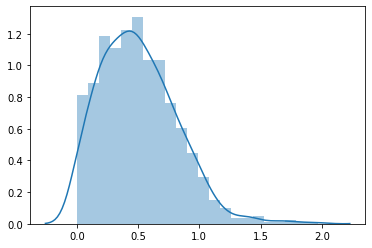

In [195]:
# More eda, checking distributions
sns.distplot(dict_31_ppg)
sns.distplot(dict_30_ppg)

In [18]:
# Quick Cohen's d function to check importance

def cohen_d(x,y):
    nx = len(x)
    ny = len(y)
    dof = nx + ny - 2
    return (np.average(x) - np.average(y)) / np.sqrt(((nx-1)*np.std(x, ddof=1) ** 2 + (ny-1)*np.std(y, ddof=1) ** 2) / dof)

In [107]:
cohen_d(dict_30_ppg_for_31, dict_31_ppg)

0.1639942746802788

The above shows a small importance, even though there was a statistical significance from earlier.  So, while we can confidently say that point totals do drop as players age from 30 to 31, the result isn't so important.

In [110]:
cohen_d(dict_30_ppg_for_35, dict_35_ppg), (np.average(dict_30_ppg_for_35) - np.average(dict_35_ppg))*82

(0.5488112148466031, 14.041078383027141)

In [20]:
cohen_d(bootstrap_means_after, bootstrap_means_before)

-12.298505213405171

MASSIVELY important.  However, this wasn't statistically significant for our tests.  Originally, we expected the rule changes to make scores go UP.  According to our tests, scores went DOWN.  Also, we find this data a bit suspicious since it is based on bootstrapped sample means.

In [21]:
cohen_d(listofgoalgpgBefore, listofgoalgpgAfter)


0.28737943313414793

This represents a medium importance level.  But again, this is in the wrong direction according to our hypothesis.

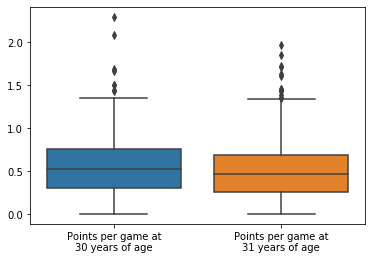

In [137]:
# Showing the tiny drop off in points per game.  The outliers are a 
# little more drastic, but outliers tend to be drastic anyway.
sns.boxplot( x=['Points per game at\n30 years of age', 'Points per game at\n31 years of age'], y=[dict_30_ppg_for_31, dict_31_ppg]);

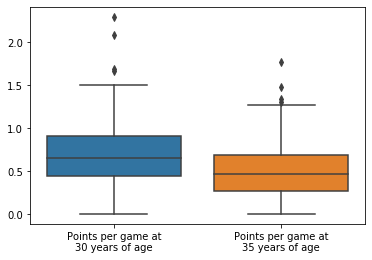

In [138]:
sns.boxplot( x=['Points per game at\n30 years of age', 'Points per game at\n35 years of age'], y=[dict_30_ppg_for_35, dict_35_ppg]);

In [ ]:
# Initializing varibables
teamgoalsdict = {}
yeardict = {}
listofgoalgpgBefore = []
listofgoalgpgAfter = []

# The ten seasons prior to the rule changes
seasonindices = ['19931994', '19941995', '19951996', '19961997', '19971998', '19981999', '19992000', '20002001', '20012002', '20022003']

# This for loop makes an API call for each season and then 
# puts each team's GPG into a list
for index in seasonindices:
#     print(index)
    yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=' + index
    r = requests.get(yearhtml, auth=('user', 'pass'))
    nestdict = r.json()
    for i in range(len(nestdict['teams'])):
#         name = nestdict['teams'][i]['teamStats'][0]['splits'][0]['team']['name']
        goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
        listofgoalgpgBefore.append(goalsPerGame)

# The ten seasons after the rule changes
seasonindicesaft = ['20062007', '20072008', '20082009', '20092010', '20102011', '20112012', '20122013', '20132014', '20142015', '20152016']

# This for loop makes an API call for each season and then 
# puts each team's GPG into a list
for index in seasonindicesaft:
#     print(index)
    yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=' + index
    r = requests.get(yearhtml, auth=('user', 'pass'))
    nestdict = r.json()
    for i in range(len(nestdict['teams'])):
#         name = nestdict['teams'][i]['teamStats'][0]['splits'][0]['team']['name']
        goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
        listofgoalgpgAfter.append(goalsPerGame)                

In [114]:
teamGoalsPerGame_04 = {}
teamGoalsPerGame_06 = {}
teamGoalsPerGame_07 = {}
teamGoalsPerGame_08 = {}
teamGoalsPerGame_09 = {}
teamGoalsPerGame_10 = {}
teamGoalsPerGame_11 = {}
teamGoalsPerGame_12 = {}

yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20032004'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()


for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_04[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20052006'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_06[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20062007'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_07[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20072008'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_08[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20082009'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_09[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20092010'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_10[name] = goalsPerGame
    

yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20102011'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_11[name] = goalsPerGame
    
yearhtml = 'https://statsapi.web.nhl.com/api/v1/teams?expand=team.stats&season=20112012'
r = requests.get(yearhtml, auth=('user', 'pass'))
nestdict = r.json()

for i in range(len(nestdict['teams'])):
    name = nestdict['teams'][i]['name']
    goalsPerGame = nestdict['teams'][i]['teamStats'][0]['splits'][0]['stat']['goalsPerGame']
    teamGoalsPerGame_12[name] = goalsPerGame
    
teamGoalsPerGame_12, teamGoalsPerGame_04



({'New Jersey Devils': 2.634,
  'New York Islanders': 2.39,
  'New York Rangers': 2.707,
  'Philadelphia Flyers': 3.171,
  'Pittsburgh Penguins': 3.329,
  'Boston Bruins': 3.171,
  'Buffalo Sabres': 2.573,
  'Montréal Canadiens': 2.524,
  'Ottawa Senators': 2.963,
  'Toronto Maple Leafs': 2.768,
  'Carolina Hurricanes': 2.585,
  'Florida Panthers': 2.402,
  'Tampa Bay Lightning': 2.829,
  'Washington Capitals': 2.659,
  'Chicago Blackhawks': 2.939,
  'Detroit Red Wings': 2.915,
  'Nashville Predators': 2.829,
  'St. Louis Blues': 2.512,
  'Calgary Flames': 2.427,
  'Colorado Avalanche': 2.427,
  'Edmonton Oilers': 2.524,
  'Vancouver Canucks': 2.939,
  'Anaheim Ducks': 2.451,
  'Dallas Stars': 2.488,
  'Los Angeles Kings': 2.293,
  'Phoenix Coyotes': 2.561,
  'San Jose Sharks': 2.671,
  'Columbus Blue Jackets': 2.415,
  'Minnesota Wild': 2.024,
  'Winnipeg Jets': 2.695},
 {'New Jersey Devils': 2.598,
  'New York Islanders': 2.89,
  'New York Rangers': 2.512,
  'Philadelphia Flyers': 2.

In [141]:
gpg04 = []
gpg06 = []
gpg07 = []
gpg08 = []
gpg09 = []
gpg10 = []
gpg11 = []

diff = 0


for teamname in teamGoalsPerGame_04.keys():
    gpg04.append(teamGoalsPerGame_04[teamname])
    gpg06.append(teamGoalsPerGame_06[teamname])
    gpg07.append(teamGoalsPerGame_07[teamname])
    gpg08.append(teamGoalsPerGame_08[teamname])
    gpg09.append(teamGoalsPerGame_09[teamname])
    gpg10.append(teamGoalsPerGame_10[teamname])
    gpg11.append(teamGoalsPerGame_11[teamname])
    
# for teamname in teamGoalsPerGame_04.keys():
#     if teamname not in teamGoalsPerGame_12.keys():
#         continue
#     elif teamname in teamGoalsPerGame_12.keys():
        
    
    
    
# Paired t-test
stats.ttest_rel(gpg04, gpg06)



Ttest_relResult(statistic=-8.430935861838218, pvalue=2.7254557252413516e-09)

In [144]:
meanofnextfiveseasons = np.array(gpg06)+np.array(gpg07)+np.array(gpg08)+np.array(gpg09)+np.array(gpg10)
meanofnextfiveseasons = meanofnextfiveseasons/5
stats.ttest_rel(gpg04, meanofnextfiveseasons)

Ttest_relResult(statistic=-5.258912208578422, pvalue=1.2351911502708235e-05)

In [189]:
from statsmodels.stats.anova import AnovaRM

dftest = pd.DataFrame(teamGoalsPerGame_04, range(1, 30))

dftest = dftest.T

dftest = dftest.loc[:,1]

dftest2 = pd.DataFrame(teamGoalsPerGame_06, range(1, 30))

dftest2 = dftest2.T

dftest2 = dftest2.loc[:,1]

dftest3 = pd.DataFrame(teamGoalsPerGame_07, range(1, 30))

dftest3 = dftest3.T

dftest3 = dftest3.loc[:,1]

dftest4 = pd.DataFrame(teamGoalsPerGame_08, range(1, 30))

dftest4 = dftest4.T

dftest4 = dftest4.loc[:,1]

dftest5 = pd.DataFrame(teamGoalsPerGame_09, range(1, 30))

dftest5 = dftest5.T

dftest5 = dftest5.loc[:,1]

dftest6 = pd.DataFrame(teamGoalsPerGame_10, range(1, 30))

dftest6 = dftest6.T

dftest6 = dftest6.loc[:,1]

sub_id = [1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30]

dfForAnova = pd.DataFrame({'sub_id': sub_id, '2004': dftest, '2006': dftest2, '2007': dftest3, '2008': dftest4, '2009': dftest5, '2010': dftest6})

dfForAnova

,sub_id,2004,2006,2007,2008,2009,2010
New Jersey Devils,1,2.598,2.841,2.512,2.415,2.902,2.634
New York Islanders,2,2.890,2.695,2.927,2.305,2.415,2.610
New York Rangers,3,2.512,3.049,2.841,2.500,2.439,2.671
Philadelphia Flyers,4,2.793,3.207,2.598,2.988,3.171,2.829
Pittsburgh Penguins,5,2.317,2.963,3.256,2.927,3.146,3.037
Boston Bruins,6,2.549,2.780,2.561,2.512,3.293,2.390
Buffalo Sabres,7,2.683,3.366,3.634,3.061,2.951,2.817
Montréal Canadiens,8,2.537,2.939,2.915,3.134,2.951,2.561
Ottawa Senators,9,3.195,3.805,3.488,3.146,2.598,2.683
Toronto Maple Leafs,10,2.951,3.098,3.098,2.780,2.976,2.561


TypeError: argument of type 'NoneType' is not iterable

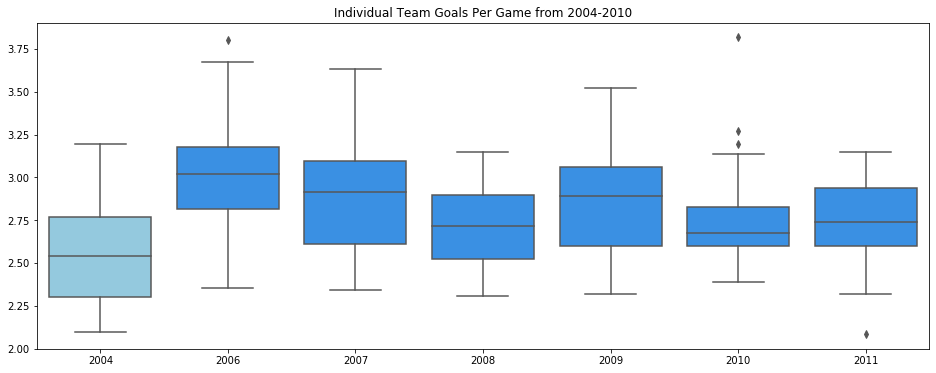

In [183]:
my_pal = {'2004': 'skyblue', '2006': 'dodgerblue', '2007': 'dodgerblue', '2008': 'dodgerblue', '2009': 'dodgerblue', '2010': 'dodgerblue', '2011': 'dodgerblue'}
plt.figure(figsize=(16, 6))
plt.title('Individual Team Goals Per Game from 2004-2010')
sns.boxplot( x=['2004', '2006', '2007', '2008', '2009', '2010', '2011'], y=[gpg04, gpg06, gpg07, gpg08, gpg09, gpg10, gpg11], palette=my_pal)

,Season,Player,Age,Tm,Pos,GP,G,GPG,A,PTS,...,SHA,S,S%,TOI,ATOI,BLK,HIT,FOwin,FOloss,FO%
0,2018,Justin Abdelkader,30.0,DET,LW,75,13,0.1733,22,35,...,-,110,12,"1,241",16:33,40.0,174.0,47.0,50.0,48.5
1,2018,Pontus Aberg,24.0,TOT,LW,53,4,0.0755,12,16,...,-,70,6,645,12:10,8.0,24.0,4.0,8.0,33.3
2,2018,Noel Acciari,26.0,BOS,C,60,10,0.1667,1,11,...,-,66,15,775,12:55,41.0,152.0,42.0,51.0,45.2
3,2018,Kenny Agostino,25.0,BOS,LW,5,-,0.0000,1,1,...,-,11,-,60,12:03,1.0,4.0,0.0,1.0,0.0
4,2018,Sebastian Aho,20.0,CAR,RW,78,29,0.3718,36,65,...,-,200,15,"1,398",17:55,17.0,65.0,78.0,94.0,45.3
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
37820,1940,Gordie Drillon*,26.0,TOR,RW,43,21,0.4884,19,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37821,1940,Bill Cowley*,27.0,BOS,C,48,13,0.2708,27,40,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37822,1940,Woody Dumart*,23.0,BOS,LW,48,22,0.4583,21,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
37823,1940,Bobby Bauer*,24.0,BOS,RW,48,17,0.3542,26,43,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [126]:
age_series = df.groupby(['Season']).mean().Age

In [134]:
age_series[2008]

26.807079646017698

In [140]:
import sklearn